In [1]:
# モジュールのインポート
import numpy as np  # 数値計算や配列操作を行うためのライブラリ
import pandas as pd  # 表形式のデータを扱うためのライブラリ
import matplotlib.pyplot as plt  # データ可視化のための基本的なグラフ描画ライブラリ
import seaborn as sns  # 高機能な統計グラフを描画するライブラリ

from sklearn.preprocessing import MultiLabelBinarizer
from lightgbm import LGBMRegressor
import optuna
from sklearn.model_selection import cross_val_predict, KFold
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from catboost import CatBoostRegressor
import geopandas as gpd

import warnings
warnings.filterwarnings('ignore')

/net/nas8/data/home/murakami/SIGNATE/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 読み込むデータが格納されたディレクトリのパス
PATH = '/home/murakami/SIGNATE/mlit-geospatial-challenge-2/data/'

train = pd.read_csv(PATH + 'train.csv')  # 学習用データの読み込み
test = pd.read_csv(PATH + 'test.csv')    # テスト用データの読み込み

print('Train:', train.shape)
print('Test:', test.shape)

Train: (363924, 149)
Test: (112437, 149)


In [3]:
pd.set_option('display.max_columns', None)
train.head()

,target_ym,money_room,building_id,building_status,building_create_date,building_modify_date,building_type,building_name,building_name_ruby,homes_building_name,homes_building_name_ruby,unit_count,full_address,lon,lat,building_structure,total_floor_area,building_area,floor_count,basement_floor_count,year_built,building_land_area,land_area_all,unit_area_min,unit_area_max,building_land_chimoku,land_youto,land_toshi,land_chisei,land_area_kind,land_setback_flg,land_setback,land_kenpei,land_youseki,land_road_cond,land_seigen,building_area_kind,management_form,management_association_flg,reform_exterior,reform_exterior_other,reform_exterior_date,reform_common_area,reform_common_area_date,building_tag_id,unit_id,unit_name,name_ruby,room_floor,balcony_area,dwelling_unit_window_angle,room_count,unit_area,floor_plan_code,reform_date,reform_place,reform_place_other,reform_wet_area,reform_wet_area_other,reform_wet_area_date,reform_interior,reform_interior_other,reform_interior_date,reform_etc,renovation_date,renovation_etc,unit_tag_id,bukken_id,snapshot_create_date,new_date,snapshot_modify_date,timelimit_date,bukken_type,flg_investment,empty_number,empty_contents,post1,post2,addr1_1,addr1_2,addr2_name,addr3_name,nl,el,rosen_name1,eki_name1,bus_stop1,bus_time1,walk_distance1,rosen_name2,eki_name2,bus_stop2,bus_time2,walk_distance2,traffic_other,traffic_car,snapshot_land_area,snapshot_land_shidou,land_shidou_a,land_shidou_b,land_mochibun_a,land_mochibun_b,house_area,flg_new,house_kanrinin,room_kaisuu,snapshot_window_angle,madori_number_all,madori_kind_all,money_kyoueki,money_kyoueki_tax,money_rimawari_now,money_shuuzen,money_shuuzenkikin,money_sonota_str1,money_sonota1,money_sonota_str2,money_sonota2,money_sonota_str3,money_sonota3,parking_money,parking_money_tax,parking_kubun,parking_distance,parking_number,parking_memo,genkyo_code,usable_status,usable_date,school_ele_name,school_ele_distance,school_ele_code,school_jun_name,school_jun_distance,school_jun_code,convenience_distance,super_distance,hospital_distance,park_distance,drugstore_distance,bank_distance,shopping_street_distance,est_other_name,est_other_distance,statuses,parking_keiyaku,money_hoshou_company,free_rent_duration,free_rent_gen_timing
0,201901,13980000,206271,1,2014-06-27 21:09:41,2019-01-24 00:10:08,4,NaN,NaN,桑名市東正和台7丁目10-11,NaN,NaN,三重県桑名市東正和台7丁目10-11,136.637467,35.047688,1.0,106.820000,NaN,2.0,NaN,199204.0,188.490005,188.490005,NaN,NaN,1.0,1.0,1.0,NaN,1.0,NaN,NaN,50.0,80.0,NaN,NaN,1.0,NaN,NaN,NaN,外壁塗装,201807.0,NaN,NaN,210202/210301/210101,262186,NaN,NaN,NaN,NaN,NaN,4.0,106.820000,450.0,NaN,NaN,NaN,1/2/3/4,NaN,201807.0,NaN,畳表替え,201807.0,NaN,NaN,NaN,310501/220701/220601/230401,360840,2018-10-30 00:00:00,2018-10-30 00:00:00,2019-01-22 13:20:11,2019-02-05 00:00:00,1202,NaN,1.0,NaN,511.0,932.0,24,205,東正和台7丁目,NaN,126159934.0,491905398.0,三岐鉄道北勢線,在良,NaN,NaN,1840.0,NaN,NaN,NaN,NaN,NaN,コミュニティバス「東正和台」停より約 500m,NaN,188.49,NaN,NaN,NaN,NaN,NaN,106.82,0.0,NaN,NaN,NaN,4,50,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,NaN,2.0,NaN,2.0,1,NaN,桑部小学校,2000.0,NaN,正和中学校,2000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,210101/220701/220601/230401/310501/210301/210202,NaN,NaN,NaN,NaN
1,201901,24480000,83315,1,2014-06-27 21:09:43,2019-04-03 00:10:08,4,NaN,NaN,桑名市松ノ木5丁目,NaN,1.0,三重県桑名市松ノ木5丁目14-8,136.639936,35.074625,10.0,NaN,NaN,2.0,NaN,198108.0,290.519989,NaN,NaN,NaN,NaN,1.0,1.0,1.0,2.0,1.0,1.2,50.0,80.0,1.0,NaN,NaN,NaN,NaN,2,外壁塗装,201706.0,NaN,NaN,330501/210301/210101/210201,35726,NaN,NaN,NaN,NaN,5.0,4.0,134.039993,450.0,NaN,NaN,NaN,1/2/3/4,キッチン・ユニットバス・洗面化粧台コーティング/トイレ新品,201706.0,2/4,NaN,201706.0,NaN,2017-06-01,外装外壁塗装 内装システムキッチン新品/お風呂新品/洗面台新品/トイレ新品/フローリング上張...,260201/260301/220801/230601/260101/230101/2203...,267022,2018-10-30 00:00:00,2018-10-30 00:00:00,2019-01-30 15:15:49,2019-02-13 00:00:00,1202,NaN,NaN,NaN,511.0,902.0,24,205,松ノ木5丁目,NaN,126256831.0,491914000.0,三岐鉄道北勢線,星川,NaN,NaN,1920.0,NaN,NaN,NaN,NaN,NaN,コミュニティバス「法務局前」停より約400m,NaN,290.52,NaN,NaN,NaN,NaN,NaN,134.04,0.0,NaN,NaN,NaN,4,50,NaN,3

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363924 entries, 0 to 363923
Columns: 149 entries, target_ym to free_rent_gen_timing
dtypes: float64(92), int64(13), object(44)
memory usage: 413.7+ MB


<Axes: xlabel='money_room', ylabel='Count'>

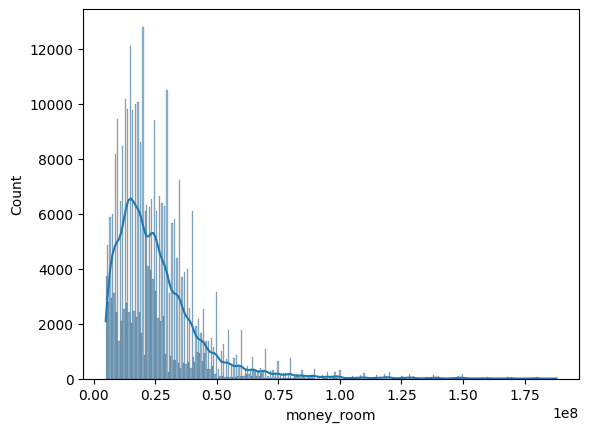

In [5]:
# 可視化（分布：ヒストグラム）
sns.histplot(train["money_room"], kde=True)

   target_ym  year
0     201901  2019
1     201901  2019
2     201901  2019
3     201901  2019
4     201901  2019
year
2019    21000000.0
2020    21600000.0
2021    21800000.0
2022    23500000.0
Name: money_room, dtype: float64


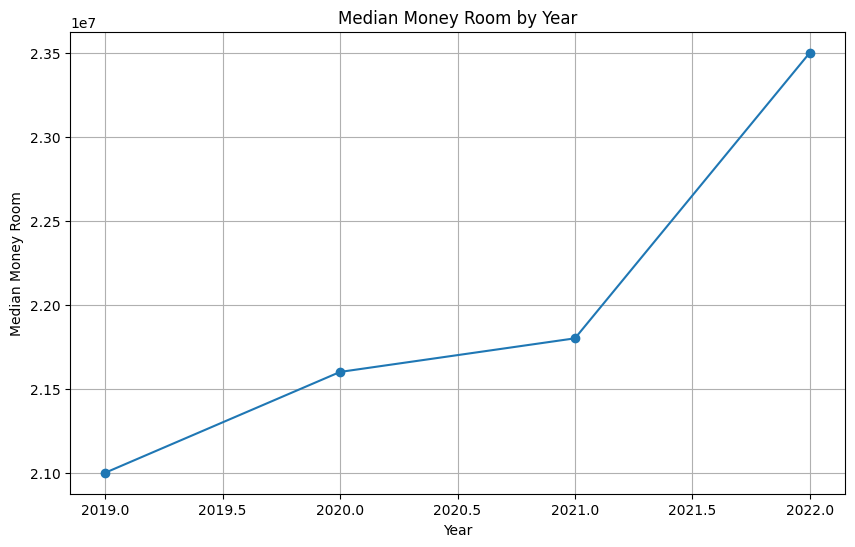

In [6]:
# 売買価格の推移
train['year'] = train['target_ym'].astype(str).str[:4].astype(int)
print(train[['target_ym', 'year']].head())
yearly_median_money_room = train.groupby('year')['money_room'].median()
print(yearly_median_money_room)
plt.figure(figsize=(10, 6))
yearly_median_money_room.plot(kind='line', marker='o')
plt.title('Median Money Room by Year')
plt.xlabel('Year')
plt.ylabel('Median Money Room')
plt.grid(True)
plt.show()

In [7]:
# 欠損率を計算する関数
def missing_rate(df):
    # 各列ごとの欠損率（%）
    return df.isna().mean() * 100

# train / test それぞれの欠損率・欠損数を計算
train_na_rate = missing_rate(train)
test_na_rate  = missing_rate(test)

train_na_cnt = train.isna().sum()
test_na_cnt  = test.isna().sum()

# 1つの DataFrame にまとめる
missing_summary = pd.DataFrame({
    "train_missing_pct": train_na_rate,
    "train_missing_cnt": train_na_cnt,
    "test_missing_pct":  test_na_rate,
    "test_missing_cnt":  test_na_cnt,
})

# 欠損率の高い順に並べ替え
missing_summary = missing_summary.sort_values(
    by=["train_missing_pct", "test_missing_pct"],
    ascending=False
)

# 確認
print(missing_summary.head(30)) 


                         train_missing_pct  train_missing_cnt  \
building_name_ruby              100.000000           363924.0   
free_rent_duration              100.000000           363924.0   
free_rent_gen_timing            100.000000           363924.0   
name_ruby                       100.000000           363924.0   
school_ele_code                 100.000000           363924.0   
school_jun_code                 100.000000           363924.0   
money_hoshou_company            100.000000           363924.0   
traffic_car                      99.998901           363920.0   
reform_etc                       99.882118           363495.0   
reform_place_other               99.761214           363055.0   
reform_place                     99.715325           362888.0   
reform_date                      99.651576           362656.0   
reform_common_area               99.367176           361621.0   
reform_common_area_date          99.367176           361621.0   
money_sonota_str3        

In [8]:
# ======================================
#  「完全に空の列」を3パターンに分類
#    - train & test 両方 100% 欠損
#    - train だけ 100% 欠損
#    - test だけ 100% 欠損
# ======================================
empty_train = missing_summary.index[missing_summary["train_missing_pct"] == 100].tolist()
empty_test  = missing_summary.index[missing_summary["test_missing_pct"] == 100].tolist()

empty_both        = sorted(set(empty_train) & set(empty_test))
empty_only_train  = sorted(set(empty_train) - set(empty_test))
empty_only_test   = sorted(set(empty_test) - set(empty_train))

print("\n=== 完全欠損列の内訳 ===")
print("train & test 両方 100% 欠損:", empty_both)
print("train だけ 100% 欠損       :", empty_only_train)
print("test だけ 100% 欠損        :", empty_only_test)

# ======================================
#  上記 3パターンすべてを「両方のデータから削除」
# ======================================
cols_to_drop = sorted(set(empty_train) | set(empty_test))
print("\n削除する列数:", len(cols_to_drop))
print("削除する列名:", cols_to_drop)

train_clean = train.drop(columns=cols_to_drop)
test_clean  = test.drop(columns=cols_to_drop)

print("\n削除後の shape")
print("train:", train_clean.shape)
print("test :", test_clean.shape)


=== 完全欠損列の内訳 ===
train & test 両方 100% 欠損: ['building_name_ruby', 'free_rent_duration', 'free_rent_gen_timing', 'name_ruby', 'school_ele_code', 'school_jun_code']
train だけ 100% 欠損       : ['money_hoshou_company']
test だけ 100% 欠損        : ['traffic_car']

削除する列数: 8
削除する列名: ['building_name_ruby', 'free_rent_duration', 'free_rent_gen_timing', 'money_hoshou_company', 'name_ruby', 'school_ele_code', 'school_jun_code', 'traffic_car']



削除後の shape
train: (363924, 142)
test : (112437, 141)


In [9]:
import os
import geopandas as gpd

STATION_ROOT = "/home/murakami/SIGNATE/mlit-geospatial-challenge-2/data/num_passengers_station"

PASSENGER_COL_MAP = {
    2019: "S12_041",  # 乗降客数2019
    2020: "S12_045",  # 乗降客数2020
    2021: "S12_049",  # 乗降客数2021
    2022: "S12_053",  # 乗降客数2022
    2023: "S12_057",  # ★ 追加: 乗降客数2023
}

STATION_SHP_INFO = {
    2019: dict(folder="S12-20_GML", subdir=None,      code="S12-20"),
    2020: dict(folder="S12-21_GML", subdir="UTF-8",   code="S12-21"),
    2021: dict(folder="S12-22_GML", subdir="UTF-8",   code="S12-22"),
    2022: dict(folder="S12-23_GML", subdir="UTF-8",   code="S12-23"),
    2023: dict(folder="S12-24_GML", subdir="UTF-8",   code="S12-24"),  # ★ 追加
}


def load_station_gdf(year: int) -> gpd.GeoDataFrame:
    """指定年の駅別乗降客数データ（全国）を読み込んで前処理した GeoDataFrame を返す"""

    info = STATION_SHP_INFO[year]

    if info["subdir"] is None:
        shp_path = os.path.join(
            STATION_ROOT,
            info["folder"],
            f"{info['code']}_NumberOfPassengers.shp",
        )
    else:
        shp_path = os.path.join(
            STATION_ROOT,
            info["folder"],
            info["subdir"],
            f"{info['code']}_NumberOfPassengers.shp",
        )

    print(f"[{year}] loading station shapefile from: {shp_path}")
    gdf = gpd.read_file(shp_path)

    passenger_col = PASSENGER_COL_MAP[year]

    # 念のため大小文字違いも許容
    if passenger_col not in gdf.columns:
        lower_map = {c.lower(): c for c in gdf.columns}
        if passenger_col.lower() in lower_map:
            passenger_col = lower_map[passenger_col.lower()]
        else:
            raise KeyError(f"{passenger_col} not found in columns: {list(gdf.columns)}")

    # どの年でも共通して '乗降客数' という名前にそろえる
    target_cols = ["S12_001", passenger_col, "geometry"]
    gdf = gdf[target_cols].rename(columns={
        "S12_001": "駅名",
        passenger_col: "乗降客数",
    })

    # 乗降客数の大きいものを優先し、駅名＋geometry で重複削除
    gdf = (
        gdf.sort_values("乗降客数", ascending=False)
           .drop_duplicates(subset=["駅名", "geometry"], keep="first")
    )

    return gdf


# 2019〜2023 年の駅データを読み込んで dict に保持（★ 2023 を追加）
station_gdfs = {year: load_station_gdf(year) for year in [2019, 2020, 2021, 2022, 2023]}


[2019] loading station shapefile from: /home/murakami/SIGNATE/mlit-geospatial-challenge-2/data/num_passengers_station/S12-20_GML/S12-20_NumberOfPassengers.shp


[2020] loading station shapefile from: /home/murakami/SIGNATE/mlit-geospatial-challenge-2/data/num_passengers_station/S12-21_GML/UTF-8/S12-21_NumberOfPassengers.shp


[2021] loading station shapefile from: /home/murakami/SIGNATE/mlit-geospatial-challenge-2/data/num_passengers_station/S12-22_GML/UTF-8/S12-22_NumberOfPassengers.shp


[2022] loading station shapefile from: /home/murakami/SIGNATE/mlit-geospatial-challenge-2/data/num_passengers_station/S12-23_GML/UTF-8/S12-23_NumberOfPassengers.shp


[2023] loading station shapefile from: /home/murakami/SIGNATE/mlit-geospatial-challenge-2/data/num_passengers_station/S12-24_GML/UTF-8/S12-24_NumberOfPassengers.shp


In [10]:
# ============================
# 800m圏内の駅数・乗降客数合計を付与
# ============================

def add_station_features(df: pd.DataFrame,
                         station_gdfs: dict,
                         buffer_m: float = 800.0) -> pd.DataFrame:
    """
    df（train_clean or test_clean）に対して、
    ・station_count_800m
    ・total_passengers_800m
    を追加して返す。

    年ごとに対応する shapefile を使うため、target_ym から year を取得して紐づける。
    """
    df_out = df.copy()

    # lon / lat がない行は計算できないので、とりあえず 0 を入れる前提
    df_out["station_count_800m"] = 0
    df_out["total_passengers_800m"] = 0.0

    mask_coord = df_out["lon"].notna() & df_out["lat"].notna()
    if mask_coord.sum() == 0:
        # そもそも座標がないならそのまま返す
        return df_out

    # 対象年（例: 201912 → 2019）
    df_valid = df_out.loc[mask_coord].copy()
    df_valid["target_year_tmp"] = df_valid["target_ym"].astype(str).str[:4].astype(int)

    # GeoDataFrame に変換（WGS84）
    gdf_base = gpd.GeoDataFrame(
        df_valid,
        geometry=gpd.points_from_xy(df_valid["lon"], df_valid["lat"]),
        crs="EPSG:4326",
    )
    # メートル座標系（日本向け）に変換
    gdf_base_m = gdf_base.to_crs(epsg=6677)

    # 初期値 0
    gdf_base_m["station_count_800m"] = 0
    gdf_base_m["total_passengers_800m"] = 0.0

    for year, gdf_station in station_gdfs.items():
        # 該当年のレコードだけ取り出し
        mask_year = gdf_base_m["target_year_tmp"] == year
        if mask_year.sum() == 0:
            continue

        gdf_year = gdf_base_m.loc[mask_year].copy()

        # 800m バッファ（円）を作成
        gdf_year["geometry"] = gdf_year.geometry.buffer(buffer_m)

        # 駅側もメートル座標系に変換
        gdf_station_m = gdf_station.to_crs(epsg=6677)

        # 空間結合（円と駅ポイントの intersects）
        joined = gpd.sjoin(
            gdf_year,
            gdf_station_m[["駅名", "乗降客数", "geometry"]],
            how="left",
            predicate="intersects",
        )

        # インデックス（元の行）単位で集計
        stats = joined.groupby(joined.index).agg(
            station_count=("駅名", "count"),
            total_passengers=("乗降客数", "sum"),
        )

        # 結果を元の gdf_base_m に書き戻し
        gdf_base_m.loc[stats.index, "station_count_800m"] = stats["station_count"].astype(int)
        gdf_base_m.loc[stats.index, "total_passengers_800m"] = stats["total_passengers"].fillna(0.0)

    # geometry と一時列を落として DataFrame に戻す
    df_valid_with_feat = pd.DataFrame(gdf_base_m.drop(columns="geometry"))
    df_valid_with_feat = df_valid_with_feat.drop(columns="target_year_tmp")

    # 元 df_out にマージ（座標のある行だけ上書き）
    df_out.loc[df_valid_with_feat.index, ["station_count_800m", "total_passengers_800m"]] = \
        df_valid_with_feat[["station_count_800m", "total_passengers_800m"]].values

    # 型を整える
    df_out["station_count_800m"] = df_out["station_count_800m"].fillna(0).astype("int16")
    df_out["total_passengers_800m"] = df_out["total_passengers_800m"].fillna(0.0).astype("float32")

    return df_out


# ---- train_clean / test_clean に適用 ----
train_clean = add_station_features(train_clean, station_gdfs)
test_clean  = add_station_features(test_clean, station_gdfs)

print("駅特徴量追加後 shape")
print("train_clean:", train_clean.shape)
print("test_clean :", test_clean.shape)
print(train_clean[["station_count_800m", "total_passengers_800m"]].describe())


駅特徴量追加後 shape
train_clean: (363924, 144)
test_clean : (112437, 143)
       station_count_800m  total_passengers_800m
count       363924.000000           3.639240e+05
mean             1.377010           5.538320e+04
std              2.079038           1.813950e+05
min              0.000000           0.000000e+00
25%              0.000000           0.000000e+00
50%              1.000000           3.143000e+03
75%              2.000000           3.876900e+04
max             21.000000           5.724403e+06


In [11]:
pd.set_option('display.max_columns', None)
train_clean.head()

,target_ym,money_room,building_id,building_status,building_create_date,building_modify_date,building_type,building_name,homes_building_name,homes_building_name_ruby,unit_count,full_address,lon,lat,building_structure,total_floor_area,building_area,floor_count,basement_floor_count,year_built,building_land_area,land_area_all,unit_area_min,unit_area_max,building_land_chimoku,land_youto,land_toshi,land_chisei,land_area_kind,land_setback_flg,land_setback,land_kenpei,land_youseki,land_road_cond,land_seigen,building_area_kind,management_form,management_association_flg,reform_exterior,reform_exterior_other,reform_exterior_date,reform_common_area,reform_common_area_date,building_tag_id,unit_id,unit_name,room_floor,balcony_area,dwelling_unit_window_angle,room_count,unit_area,floor_plan_code,reform_date,reform_place,reform_place_other,reform_wet_area,reform_wet_area_other,reform_wet_area_date,reform_interior,reform_interior_other,reform_interior_date,reform_etc,renovation_date,renovation_etc,unit_tag_id,bukken_id,snapshot_create_date,new_date,snapshot_modify_date,timelimit_date,bukken_type,flg_investment,empty_number,empty_contents,post1,post2,addr1_1,addr1_2,addr2_name,addr3_name,nl,el,rosen_name1,eki_name1,bus_stop1,bus_time1,walk_distance1,rosen_name2,eki_name2,bus_stop2,bus_time2,walk_distance2,traffic_other,snapshot_land_area,snapshot_land_shidou,land_shidou_a,land_shidou_b,land_mochibun_a,land_mochibun_b,house_area,flg_new,house_kanrinin,room_kaisuu,snapshot_window_angle,madori_number_all,madori_kind_all,money_kyoueki,money_kyoueki_tax,money_rimawari_now,money_shuuzen,money_shuuzenkikin,money_sonota_str1,money_sonota1,money_sonota_str2,money_sonota2,money_sonota_str3,money_sonota3,parking_money,parking_money_tax,parking_kubun,parking_distance,parking_number,parking_memo,genkyo_code,usable_status,usable_date,school_ele_name,school_ele_distance,school_jun_name,school_jun_distance,convenience_distance,super_distance,hospital_distance,park_distance,drugstore_distance,bank_distance,shopping_street_distance,est_other_name,est_other_distance,statuses,parking_keiyaku,year,station_count_800m,total_passengers_800m
0,201901,13980000,206271,1,2014-06-27 21:09:41,2019-01-24 00:10:08,4,NaN,桑名市東正和台7丁目10-11,NaN,NaN,三重県桑名市東正和台7丁目10-11,136.637467,35.047688,1.0,106.820000,NaN,2.0,NaN,199204.0,188.490005,188.490005,NaN,NaN,1.0,1.0,1.0,NaN,1.0,NaN,NaN,50.0,80.0,NaN,NaN,1.0,NaN,NaN,NaN,外壁塗装,201807.0,NaN,NaN,210202/210301/210101,262186,NaN,NaN,NaN,NaN,4.0,106.820000,450.0,NaN,NaN,NaN,1/2/3/4,NaN,201807.0,NaN,畳表替え,201807.0,NaN,NaN,NaN,310501/220701/220601/230401,360840,2018-10-30 00:00:00,2018-10-30 00:00:00,2019-01-22 13:20:11,2019-02-05 00:00:00,1202,NaN,1.0,NaN,511.0,932.0,24,205,東正和台7丁目,NaN,126159934.0,491905398.0,三岐鉄道北勢線,在良,NaN,NaN,1840.0,NaN,NaN,NaN,NaN,NaN,コミュニティバス「東正和台」停より約 500m,188.49,NaN,NaN,NaN,NaN,NaN,106.82,0.0,NaN,NaN,NaN,4,50,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,NaN,2.0,NaN,2.0,1,NaN,桑部小学校,2000.0,正和中学校,2000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,210101/220701/220601/230401/310501/210301/210202,NaN,2019,0,0.0
1,201901,24480000,83315,1,2014-06-27 21:09:43,2019-04-03 00:10:08,4,NaN,桑名市松ノ木5丁目,NaN,1.0,三重県桑名市松ノ木5丁目14-8,136.639936,35.074625,10.0,NaN,NaN,2.0,NaN,198108.0,290.519989,NaN,NaN,NaN,NaN,1.0,1.0,1.0,2.0,1.0,1.2,50.0,80.0,1.0,NaN,NaN,NaN,NaN,2,外壁塗装,201706.0,NaN,NaN,330501/210301/210101/210201,35726,NaN,NaN,NaN,5.0,4.0,134.039993,450.0,NaN,NaN,NaN,1/2/3/4,キッチン・ユニットバス・洗面化粧台コーティング/トイレ新品,201706.0,2/4,NaN,201706.0,NaN,2017-06-01,外装外壁塗装 内装システムキッチン新品/お風呂新品/洗面台新品/トイレ新品/フローリング上張...,260201/260301/220801/230601/260101/230101/2203...,267022,2018-10-30 00:00:00,2018-10-30 00:00:00,2019-01-30 15:15:49,2019-02-13 00:00:00,1202,NaN,NaN,NaN,511.0,902.0,24,205,松ノ木5丁目,NaN,126256831.0,491914000.0,三岐鉄道北勢線,星川,NaN,NaN,1920.0,NaN,NaN,NaN,NaN,NaN,コミュニティバス「法務局前」停より約400m,290.52,NaN,NaN,NaN,NaN,NaN,134.04,0.0,NaN,NaN,NaN,4,50,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,NaN,3.0,NaN,2.0,1,NaN,大山田南小学校,350.0,陵成中学校,1100.0,NaN,NaN,NaN,NaN,NaN,N

In [12]:
# 連続値として扱いたい「純粋な数値特徴量」
numerical_columns = [
    "unit_count",
    "lon",
    "lat",
    "total_floor_area",
    "building_area",
    "floor_count",
    "basement_floor_count",
    "building_land_area",
    "land_area_all",
    "unit_area_min",
    "unit_area_max",
    "land_setback",
    "land_kenpei",
    "land_youseki",
    "room_floor",
    "balcony_area",
    "room_count",
    "unit_area",
    "empty_number",
    "nl",
    "el",
    "bus_time1",
    "walk_distance1",
    "bus_time2",
    "walk_distance2",
    "traffic_car",
    "snapshot_land_area",
    "snapshot_land_shidou",
    "land_shidou_a",
    "land_shidou_b",
    "land_mochibun_a",
    "land_mochibun_b",
    "house_area",
    "room_kaisuu",
    "madori_number_all",
    "money_kyoueki",
    "money_rimawari_now",
    "money_shuuzen",
    "money_shuuzenkikin",
    "money_sonota1",
    "money_sonota2",
    "money_sonota3",
    "parking_money",
    "parking_distance",
    "parking_number",
    "school_ele_distance",
    "school_jun_distance",
    "convenience_distance",
    "super_distance",
    "hospital_distance",
    "park_distance",
    "drugstore_distance",
    "bank_distance",
    "shopping_street_distance",
    "est_other_distance",
    "free_rent_duration",
]

# 数値コードで表現されているカテゴリ（名義尺度）
cat_num_cols = [
    "building_status",
    "building_type",
    "building_structure",
    "building_land_chimoku",
    "land_youto",
    "land_toshi",
    "land_chisei",
    "land_area_kind",
    "land_setback_flg",
    "land_road_cond",
    "building_area_kind",
    "management_form",
    "management_association_flg",
    "bukken_type",
    "flg_investment",
    "post1",
    "post2",
    "addr1_1",
    "addr1_2",
    "flg_new",
    "house_kanrinin",
    "snapshot_window_angle",
    "madori_kind_all",
    "money_kyoueki_tax",
    "parking_money_tax",
    "parking_kubun",
    "genkyo_code",
    "usable_status",
    "parking_keiyaku",
    "money_hoshou_company",
    "dwelling_unit_window_angle",
    "floor_plan_code",            
    "school_ele_code",            
    "school_jun_code",           
]


# スラッシュ区切りのマルチラベル列（全タグを展開）
slash_cols = [
    "building_tag_id",
    "unit_tag_id",
    "reform_interior",
    "reform_exterior",
    "reform_wet_area",
    "statuses",
]

# yyyymm 形式の年月列
ym_cols = [
    "year_built",
    "reform_exterior_date",
    "reform_common_area_date",
    "reform_wet_area_date",
    "reform_interior_date",
    "usable_date",
    "free_rent_gen_timing",
]

# 日時（YYYY-MM-DD HH:MM:SS）列
datetime_cols = [
    "building_create_date",
    "building_modify_date",
    "snapshot_create_date",
    "new_date",
    "snapshot_modify_date",
    "timelimit_date",
    "reform_date",
    "renovation_date",
]

# ドロップしてしまうテキスト系カラム（住所・備考など）
text_cols_to_drop = [
    "building_name",
    "building_name_ruby",
    "homes_building_name",
    "homes_building_name_ruby",
    "full_address",
    "addr2_name",
    "addr3_name",
    "empty_contents",
    "parking_memo",
    "est_other_name",
    "traffic_other",
    "school_ele_name",
    "school_jun_name",
    "reform_exterior_other",
    "reform_common_area",
    "reform_wet_area_other",
    "reform_interior_other",
    "reform_etc",
    "renovation_etc",
    "money_sonota_str1",
    "money_sonota_str2",
    "money_sonota_str3",
    "unit_name",     
    "name_ruby",      
    "reform_place",   
]




# ただのID（特徴量としては使わない）
id_cols_to_drop = [
    "building_id",
    "unit_id",
    "bukken_id",
]




In [13]:
# セル3: all_data 作成 & 前処理

# 目的変数を取り出し
TARGET_COL = "money_room"
y = train_clean[TARGET_COL].astype(float)

train_feats = train_clean.drop(columns=[TARGET_COL])
test_feats  = test_clean.copy()

# train/test を縦に結合して一括前処理
all_data = pd.concat([train_feats, test_feats], axis=0, ignore_index=True)

print("all_data shape (before):", all_data.shape)


# --------------------------
# 3-1. target_ym → target_date（必ず datetime64 に変換）
# --------------------------
def ym_to_datetime(x):
    """yyyymm 形式（201901, '201901', 201901.0 など）を Timestamp に変換"""
    if pd.isna(x):
        return pd.NaT
    s = str(x).strip()
    if s == "":
        return pd.NaT
    if "." in s:
        s = s.split(".")[0]
    s = "".join(ch for ch in s if ch.isdigit())
    if len(s) < 6:
        return pd.NaT
    year = int(s[:4])
    month = int(s[4:6])
    try:
        return pd.Timestamp(year=year, month=month, day=1)
    except Exception:
        return pd.NaT

if "target_ym" in all_data.columns:
    # ★ apply → to_datetime で datetime64 型にする
    all_data["target_date"] = pd.to_datetime(
        all_data["target_ym"].apply(ym_to_datetime),
        errors="coerce"
    )
    all_data["target_year"] = all_data["target_date"].dt.year.astype("Int16")
    all_data["target_month"] = all_data["target_date"].dt.month.astype("Int8")
else:
    all_data["target_date"] = pd.NaT
    all_data["target_year"] = np.nan
    all_data["target_month"] = np.nan


# --------------------------
# 3-2. 数値カテゴリ（名義尺度）を category 型に
# --------------------------
cat_num_cols_existing = [c for c in cat_num_cols if c in all_data.columns]

for col in cat_num_cols_existing:
    all_data[col] = all_data[col].astype("Int64")  # NaN も扱える整数
    all_data[col] = all_data[col].astype("category")

# --------------------------
# 3-3. スラッシュ区切り列のマルチホット化（全タグ）
# --------------------------
slash_cols_existing = [c for c in slash_cols if c in all_data.columns]

def split_tags(val):
    if pd.isna(val):
        return []
    s = str(val).strip()
    if not s:
        return []
    return s.split("/")

for col in slash_cols_existing:
    print(f"Processing multi-label column: {col}")
    tag_lists = all_data[col].apply(split_tags)

    mlb = MultiLabelBinarizer()
    tag_array = mlb.fit_transform(tag_lists)

    new_cols = [f"{col}_tag_{cls}" for cls in mlb.classes_]
    tag_df = pd.DataFrame(tag_array, columns=new_cols, index=all_data.index).astype("int8")

    all_data = pd.concat([all_data, tag_df], axis=1)

    # タグ数も1列追加
    all_data[f"{col}_tag_count"] = tag_lists.apply(len).astype("int16")

    # 元の文字列列は削除
    all_data.drop(columns=[col], inplace=True)

# --------------------------
# 3-4. yyyymm 列 → 年・月・経過日数（必ず datetime64 に変換）
# --------------------------
ym_cols_existing = [c for c in ym_cols if c in all_data.columns]

for col in ym_cols_existing:
    dt_col = col + "_dt"
    # ★ ここも apply → to_datetime で datetime64 型に
    all_data[dt_col] = pd.to_datetime(
        all_data[col].apply(ym_to_datetime),
        errors="coerce"
    )
    all_data[f"{col}_year"] = all_data[dt_col].dt.year
    all_data[f"{col}_month"] = all_data[dt_col].dt.month
    all_data[f"{col}_since_target_days"] = (
        (all_data["target_date"] - all_data[dt_col]).dt.days
    )

# 築年数（年）を作る
if "year_built_dt" in all_data.columns:
    all_data["building_age_years"] = (
        (all_data["target_date"] - all_data["year_built_dt"]).dt.days / 365.25
    )


# --------------------------
# 3-5. 日時列 → 年・月・日・曜日・経過日数
# --------------------------
datetime_cols_existing = [c for c in datetime_cols if c in all_data.columns]

for col in datetime_cols_existing:
    all_data[col] = pd.to_datetime(all_data[col], errors="coerce")
    all_data[f"{col}_year"] = all_data[col].dt.year
    all_data[f"{col}_month"] = all_data[col].dt.month
    all_data[f"{col}_day"] = all_data[col].dt.day
    all_data[f"{col}_dow"] = all_data[col].dt.weekday  # 0: 月〜6: 日
    all_data[f"{col}_since_target_days"] = (
        (all_data["target_date"] - all_data[col]).dt.days
    )

# 時刻（hour/minute/second）は使わない

# --------------------------
# 3-6. 生の日時/年月/target_ym/target_date を削除
# --------------------------
drop_date_cols = []

if "target_ym" in all_data.columns:
    drop_date_cols.append("target_ym")
drop_date_cols.append("target_date")

# ★ ここで元の yyyymm 列 (year_built など) 自体も消す
drop_date_cols.extend(ym_cols_existing)           # ← 追加
drop_date_cols.extend([c + "_dt" for c in ym_cols_existing])
drop_date_cols.extend(datetime_cols_existing)

all_data.drop(
    columns=[c for c in drop_date_cols if c in all_data.columns],
    inplace=True
)

print("all_data shape (after date & slash processing):", all_data.shape)



all_data shape (before): (476361, 144)


Processing multi-label column: building_tag_id


Processing multi-label column: unit_tag_id


Processing multi-label column: reform_interior


Processing multi-label column: reform_exterior


Processing multi-label column: reform_wet_area


Processing multi-label column: statuses


all_data shape (after date & slash processing): (476361, 566)


In [14]:
# セル4: 数値列の型整備 & テキスト/ID の削除 & カテゴリ列の決定

# 4-1. テキスト系・ID 系の削除
drop_cols = []

drop_cols.extend([c for c in text_cols_to_drop if c in all_data.columns])
drop_cols.extend([c for c in id_cols_to_drop if c in all_data.columns])

print("Drop text/ID columns:", drop_cols)

all_data.drop(columns=drop_cols, inplace=True)

# 4-2. 数値特徴量の型を float に
numerical_columns_existing = [c for c in numerical_columns if c in all_data.columns]

for col in numerical_columns_existing:
    all_data[col] = pd.to_numeric(all_data[col], errors="coerce")

# 4-3. スラッシュ展開で増えた 0/1 や、日付由来の *_since_target_days など、
#      int/float dtype の列は数値として扱う
extra_num_cols = [
    c for c in all_data.columns
    if (c not in numerical_columns_existing)
    and (str(all_data[c].dtype) in ["int8", "int16", "int32", "int64",
                                    "float16", "float32", "float64"])
]

numeric_all = sorted(set(numerical_columns_existing + extra_num_cols))

# 4-4. 残りで object のものはカテゴリとして扱う
obj_cols = all_data.select_dtypes(include=["object"]).columns.tolist()
for col in obj_cols:
    all_data[col] = all_data[col].astype("category")

# 名義尺度の数値カテゴリ（cat_num_cols_existing）もすでに category 型

# 4-5. カテゴリ特徴量を抽出（dtype が category の列）
categorical_features = [c for c in all_data.columns if str(all_data[c].dtype) == "category"]

print("数値特徴量数:", len(numeric_all))
print("カテゴリ特徴量数:", len(categorical_features))

# 4-6. train/test に分割
X = all_data.iloc[: len(train_clean)].copy()
X_test = all_data.iloc[len(train_clean):].copy()

print("X shape     :", X.shape)
print("X_test shape:", X_test.shape)

# 4-7. CatBoost 用にカテゴリ列の NaN を文字列で埋める
#      → cat_features は int か str で、NaN は NG なので全部 str にして欠損を "__MISSING__" にする
for col in categorical_features:
    X[col] = X[col].astype("object").fillna("__MISSING__")
    X_test[col] = X_test[col].astype("object").fillna("__MISSING__")

# 念のため NaN が残っていないか確認（0 になっていればOK）
print("残っているカテゴリNaN数 (train):", X[categorical_features].isna().sum().sum())
print("残っているカテゴリNaN数 (test) :", X_test[categorical_features].isna().sum().sum())


Drop text/ID columns: ['building_name', 'homes_building_name', 'homes_building_name_ruby', 'full_address', 'addr2_name', 'addr3_name', 'empty_contents', 'parking_memo', 'est_other_name', 'traffic_other', 'school_ele_name', 'school_jun_name', 'reform_exterior_other', 'reform_common_area', 'reform_wet_area_other', 'reform_interior_other', 'reform_etc', 'renovation_etc', 'money_sonota_str1', 'money_sonota_str2', 'money_sonota_str3', 'unit_name', 'reform_place', 'building_id', 'unit_id', 'bukken_id']


数値特徴量数: 499
カテゴリ特徴量数: 39


X shape     : (363924, 540)
X_test shape: (112437, 540)


残っているカテゴリNaN数 (train): 0
残っているカテゴリNaN数 (test) : 0


In [15]:
print("数値 (numeric_all) の例:")
print(list(numeric_all)[:30])

print("\nカテゴリ (categorical_features) の例:")
print(categorical_features[:30])

print("\nまだ category でも numeric_all でもない列（ほぼ無いはず）:")
others = [
    c for c in all_data.columns
    if c not in numeric_all and c not in categorical_features
]
print(others)


数値 (numeric_all) の例:
['balcony_area', 'bank_distance', 'basement_floor_count', 'building_age_years', 'building_area', 'building_create_date_day', 'building_create_date_dow', 'building_create_date_month', 'building_create_date_since_target_days', 'building_create_date_year', 'building_land_area', 'building_modify_date_day', 'building_modify_date_dow', 'building_modify_date_month', 'building_modify_date_since_target_days', 'building_modify_date_year', 'building_tag_id_tag_110101', 'building_tag_id_tag_110102', 'building_tag_id_tag_113501', 'building_tag_id_tag_210101', 'building_tag_id_tag_210102', 'building_tag_id_tag_210199', 'building_tag_id_tag_210201', 'building_tag_id_tag_210202', 'building_tag_id_tag_210299', 'building_tag_id_tag_210301', 'building_tag_id_tag_210302', 'building_tag_id_tag_210303', 'building_tag_id_tag_210399', 'building_tag_id_tag_210401']

カテゴリ (categorical_features) の例:
['building_status', 'building_type', 'building_structure', 'building_land_chimoku', 'land_you

In [16]:
# GPU を使うかどうか
USE_GPU = True  # ★ ここを True / False で切り替え

catboost_device_params = {}
if USE_GPU:
    catboost_device_params = {
        "task_type": "GPU",
        "devices": "0",   # GPU0 を使う場合
    }
else:
    catboost_device_params = {
        "task_type": "CPU",
    }

print("CatBoost USE_GPU =", USE_GPU)

# CatBoost に渡すための「カテゴリ特徴量のカラム index」
cat_feature_names = categorical_features  # 前処理で作ったリスト
cat_feature_indices = [X.columns.get_loc(c) for c in cat_feature_names]
print("num categorical features:", len(cat_feature_indices))


CatBoost USE_GPU = True
num categorical features: 39


In [17]:
# 生の目的変数
y_raw = y.astype(float).values

# ログ変換した目的変数（CatBoost はこっちで学習）
y_log = np.log1p(y_raw)


In [18]:
# セル1: CatBoostRegressor + Optuna (logターゲット, RMSE学習, MAPE評価)

def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 1500, 6000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 10.0, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 5.0),
        "random_strength": trial.suggest_float("random_strength", 0.0, 10.0),
        # ★ ここを MAPE ではなく RMSE 系にする
        "loss_function": "RMSE",
        "eval_metric": "RMSE",
        "random_seed": 42,
        "verbose": False,
        "allow_writing_files": False,
        "used_ram_limit": "8gb",
        "od_type": "Iter",
        "od_wait": 50,
        "use_best_model": True,
    }

    # GPU / CPU 設定
    params.update(catboost_device_params)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mape_scores = []

    for train_idx, valid_idx in kf.split(X, y_log):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train_log = y_log[train_idx]
        y_valid_log = y_log[valid_idx]
        y_valid_true = y_raw[valid_idx]  # 元スケールの y

        model = CatBoostRegressor(**params)

        model.fit(
            X_train, y_train_log,
            eval_set=(X_valid, y_valid_log),
            cat_features=cat_feature_indices,
            verbose=False,
        )

        # 予測は log スケール → 元スケールへ戻す
        y_pred_log = model.predict(X_valid)
        y_pred = np.expm1(y_pred_log)

        eps = 1e-6
        mape = np.mean(np.abs(y_valid_true - y_pred) / (np.abs(y_valid_true) + eps))
        mape_scores.append(mape)

    return np.mean(mape_scores)


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)  

print(f"Best objective value (MAPE): {study.best_value}")
print(f"Best params: {study.best_params}")


[I 2026-01-30 23:07:18,901] A new study created in memory with name: no-name-92e5e1ce-4e81-4375-93c2-cf365a3c51d3


[I 2026-01-30 23:45:58,673] Trial 0 finished with value: 0.1483321934252983 and parameters: {'iterations': 4527, 'learning_rate': 0.018605033793219063, 'depth': 10, 'l2_leaf_reg': 4.541864472982516, 'bagging_temperature': 1.2145332959759425, 'random_strength': 3.081456794813943}. Best is trial 0 with value: 0.1483321934252983.


[I 2026-01-31 00:21:08,913] Trial 1 finished with value: 0.12930778688471198 and parameters: {'iterations': 5755, 'learning_rate': 0.09674697542674783, 'depth': 8, 'l2_leaf_reg': 0.42492466885735136, 'bagging_temperature': 0.034331101327912394, 'random_strength': 4.387683555091719}. Best is trial 1 with value: 0.12930778688471198.


[I 2026-01-31 00:48:33,096] Trial 2 finished with value: 0.16304260742281823 and parameters: {'iterations': 4449, 'learning_rate': 0.05935696284331168, 'depth': 8, 'l2_leaf_reg': 0.008008657437430391, 'bagging_temperature': 4.16537323442368, 'random_strength': 3.8427462454565795}. Best is trial 1 with value: 0.12930778688471198.


[I 2026-01-31 01:01:07,887] Trial 3 finished with value: 0.1895177454041465 and parameters: {'iterations': 3492, 'learning_rate': 0.04013983081546662, 'depth': 5, 'l2_leaf_reg': 0.023027412592456872, 'bagging_temperature': 4.585203558043378, 'random_strength': 5.1958792293358425}. Best is trial 1 with value: 0.12930778688471198.


[I 2026-01-31 01:31:45,199] Trial 4 finished with value: 0.1629376219486182 and parameters: {'iterations': 4971, 'learning_rate': 0.01174899716971053, 'depth': 8, 'l2_leaf_reg': 0.0021442280499101678, 'bagging_temperature': 1.7330064495154756, 'random_strength': 3.775744775598664}. Best is trial 1 with value: 0.12930778688471198.


[I 2026-01-31 01:42:52,531] Trial 5 finished with value: 0.1647727859543741 and parameters: {'iterations': 1534, 'learning_rate': 0.06771170143225742, 'depth': 9, 'l2_leaf_reg': 0.10536137808166547, 'bagging_temperature': 3.161949805407856, 'random_strength': 1.0749957502849805}. Best is trial 1 with value: 0.12930778688471198.


[I 2026-01-31 02:16:54,497] Trial 6 finished with value: 0.14388148452862817 and parameters: {'iterations': 3927, 'learning_rate': 0.16307760648075925, 'depth': 10, 'l2_leaf_reg': 0.0023090782625620424, 'bagging_temperature': 3.18005468355905, 'random_strength': 9.587388068739477}. Best is trial 1 with value: 0.12930778688471198.


[I 2026-01-31 02:22:44,138] Trial 7 finished with value: 0.1798575178357819 and parameters: {'iterations': 2024, 'learning_rate': 0.16079863525542937, 'depth': 4, 'l2_leaf_reg': 0.02254583116430991, 'bagging_temperature': 3.3415220220302198, 'random_strength': 8.910348616388779}. Best is trial 1 with value: 0.12930778688471198.


[I 2026-01-31 02:43:26,963] Trial 8 finished with value: 0.17534025305544892 and parameters: {'iterations': 5766, 'learning_rate': 0.06521646070910823, 'depth': 5, 'l2_leaf_reg': 0.06760326257236139, 'bagging_temperature': 3.934990342193327, 'random_strength': 9.753749263547304}. Best is trial 1 with value: 0.12930778688471198.


[I 2026-01-31 03:34:25,050] Trial 9 finished with value: 0.17001191187311374 and parameters: {'iterations': 5834, 'learning_rate': 0.01633023510845216, 'depth': 10, 'l2_leaf_reg': 3.1178504786772083, 'bagging_temperature': 4.938622697390188, 'random_strength': 1.3531617757979442}. Best is trial 1 with value: 0.12930778688471198.


[I 2026-01-31 03:49:29,220] Trial 10 finished with value: 0.13628716681828817 and parameters: {'iterations': 2889, 'learning_rate': 0.23485453700312953, 'depth': 7, 'l2_leaf_reg': 0.705509286475074, 'bagging_temperature': 0.013458574615084373, 'random_strength': 6.644287980712674}. Best is trial 1 with value: 0.12930778688471198.


[I 2026-01-31 04:03:49,150] Trial 11 finished with value: 0.13674115192763098 and parameters: {'iterations': 2743, 'learning_rate': 0.2419492008359779, 'depth': 7, 'l2_leaf_reg': 0.6452210949281192, 'bagging_temperature': 0.08521025354496277, 'random_strength': 6.884577490632266}. Best is trial 1 with value: 0.12930778688471198.


[I 2026-01-31 04:19:18,639] Trial 12 finished with value: 0.136396058732877 and parameters: {'iterations': 2976, 'learning_rate': 0.2951308679365937, 'depth': 7, 'l2_leaf_reg': 0.7989434653535653, 'bagging_temperature': 0.04802032125740938, 'random_strength': 6.593959652426317}. Best is trial 1 with value: 0.12930778688471198.


[I 2026-01-31 04:31:15,871] Trial 13 finished with value: 0.14851530855922251 and parameters: {'iterations': 2702, 'learning_rate': 0.12473122436085336, 'depth': 6, 'l2_leaf_reg': 0.4376573295529737, 'bagging_temperature': 0.9415627932614847, 'random_strength': 6.806379277320945}. Best is trial 1 with value: 0.12930778688471198.


[I 2026-01-31 04:53:31,181] Trial 14 finished with value: 0.1352033250103251 and parameters: {'iterations': 3629, 'learning_rate': 0.11129029669253973, 'depth': 8, 'l2_leaf_reg': 0.18523208109360512, 'bagging_temperature': 0.7127365747724299, 'random_strength': 5.476053349806962}. Best is trial 1 with value: 0.12930778688471198.


[I 2026-01-31 05:25:16,473] Trial 15 finished with value: 0.14154292941106417 and parameters: {'iterations': 5147, 'learning_rate': 0.10404421791109084, 'depth': 8, 'l2_leaf_reg': 0.17210314915525918, 'bagging_temperature': 1.981834060278332, 'random_strength': 5.030317144639304}. Best is trial 1 with value: 0.12930778688471198.


[I 2026-01-31 05:52:47,260] Trial 16 finished with value: 0.14573925414115388 and parameters: {'iterations': 3855, 'learning_rate': 0.03376913589083716, 'depth': 9, 'l2_leaf_reg': 9.019182472980782, 'bagging_temperature': 0.833709888227333, 'random_strength': 2.5815035647729454}. Best is trial 1 with value: 0.12930778688471198.


[I 2026-01-31 06:29:46,517] Trial 17 finished with value: 0.12851228695448674 and parameters: {'iterations': 5083, 'learning_rate': 0.09894611059967887, 'depth': 9, 'l2_leaf_reg': 0.2404150597247994, 'bagging_temperature': 0.7181055962132566, 'random_strength': 7.982506780596488}. Best is trial 17 with value: 0.12851228695448674.


[I 2026-01-31 07:08:35,978] Trial 18 finished with value: 0.14217537189499066 and parameters: {'iterations': 5351, 'learning_rate': 0.08636733340812604, 'depth': 9, 'l2_leaf_reg': 1.47022660754646, 'bagging_temperature': 2.3756837680554375, 'random_strength': 8.237020924657518}. Best is trial 17 with value: 0.12851228695448674.


[I 2026-01-31 07:41:40,496] Trial 19 finished with value: 0.14269328901987965 and parameters: {'iterations': 4579, 'learning_rate': 0.03797604018111868, 'depth': 9, 'l2_leaf_reg': 0.042663239231554795, 'bagging_temperature': 1.4708557657866799, 'random_strength': 7.51751440784432}. Best is trial 17 with value: 0.12851228695448674.


[I 2026-01-31 08:08:00,628] Trial 20 finished with value: 0.1359611449057297 and parameters: {'iterations': 5980, 'learning_rate': 0.161820130956854, 'depth': 6, 'l2_leaf_reg': 0.27059204799563136, 'bagging_temperature': 0.4973577042161848, 'random_strength': 0.05213026582696312}. Best is trial 17 with value: 0.12851228695448674.


[I 2026-01-31 08:28:33,870] Trial 21 finished with value: 0.13700709712275685 and parameters: {'iterations': 3354, 'learning_rate': 0.08720325039857162, 'depth': 8, 'l2_leaf_reg': 0.2048906736209838, 'bagging_temperature': 0.5192830070816028, 'random_strength': 5.614742841846583}. Best is trial 17 with value: 0.12851228695448674.


[I 2026-01-31 09:02:30,143] Trial 22 finished with value: 0.13009689279526312 and parameters: {'iterations': 5507, 'learning_rate': 0.12874035369659054, 'depth': 8, 'l2_leaf_reg': 1.4964843866406572, 'bagging_temperature': 0.555554460039192, 'random_strength': 4.289971817833556}. Best is trial 17 with value: 0.12851228695448674.


[I 2026-01-31 09:42:52,736] Trial 23 finished with value: 0.13019483378752028 and parameters: {'iterations': 5504, 'learning_rate': 0.14071460704060396, 'depth': 9, 'l2_leaf_reg': 1.3582804363826135, 'bagging_temperature': 1.2548672990343954, 'random_strength': 4.09954608195925}. Best is trial 17 with value: 0.12851228695448674.


[I 2026-01-31 10:12:49,904] Trial 24 finished with value: 0.1389188846884836 and parameters: {'iterations': 4897, 'learning_rate': 0.04847445297032801, 'depth': 8, 'l2_leaf_reg': 2.4273715180249655, 'bagging_temperature': 0.4109603493272892, 'random_strength': 2.4189008248618067}. Best is trial 17 with value: 0.12851228695448674.


[I 2026-01-31 10:37:02,646] Trial 25 finished with value: 0.1539144008340604 and parameters: {'iterations': 5482, 'learning_rate': 0.0849396313459461, 'depth': 6, 'l2_leaf_reg': 0.38708833881395843, 'bagging_temperature': 2.11409311282638, 'random_strength': 4.361795458164204}. Best is trial 17 with value: 0.12851228695448674.


[I 2026-01-31 10:58:30,442] Trial 26 finished with value: 0.13864305508238406 and parameters: {'iterations': 4093, 'learning_rate': 0.2081443975341251, 'depth': 7, 'l2_leaf_reg': 1.3039729041521977, 'bagging_temperature': 1.0466886003136135, 'random_strength': 5.70398048303661}. Best is trial 17 with value: 0.12851228695448674.


[I 2026-01-31 11:32:51,895] Trial 27 finished with value: 0.1298293031822136 and parameters: {'iterations': 4759, 'learning_rate': 0.09315220387143335, 'depth': 9, 'l2_leaf_reg': 6.705671925172794, 'bagging_temperature': 0.3734479011857118, 'random_strength': 3.2083729636197043}. Best is trial 17 with value: 0.12851228695448674.


[I 2026-01-31 12:15:06,380] Trial 28 finished with value: 0.13507157449629026 and parameters: {'iterations': 4895, 'learning_rate': 0.0795783400160567, 'depth': 10, 'l2_leaf_reg': 6.221180279467322, 'bagging_temperature': 1.589448783467692, 'random_strength': 3.0895819415209056}. Best is trial 17 with value: 0.12851228695448674.


[I 2026-01-31 12:47:45,544] Trial 29 finished with value: 0.14794381943452997 and parameters: {'iterations': 4539, 'learning_rate': 0.027187957690212285, 'depth': 9, 'l2_leaf_reg': 4.196687774088094, 'bagging_temperature': 1.2503083254436373, 'random_strength': 3.0322476664192273}. Best is trial 17 with value: 0.12851228695448674.


Best objective value (MAPE): 0.12851228695448674
Best params: {'iterations': 5083, 'learning_rate': 0.09894611059967887, 'depth': 9, 'l2_leaf_reg': 0.2404150597247994, 'bagging_temperature': 0.7181055962132566, 'random_strength': 7.982506780596488}


In [19]:
# セル2: ベストパラメータで 5-fold CV & テスト予測 (logターゲット, RMSE学習, MAPE評価)

best_params = study.best_params.copy()

best_params.update({
    "loss_function": "RMSE",   # ★ MAPE ではなく RMSE
    "eval_metric": "RMSE",
    "random_seed": 42,
    "verbose": False,
    "allow_writing_files": False,
    "od_type": "Iter",
    "od_wait": 50,
    "use_best_model": True,
})
best_params.update(catboost_device_params)

print("Final CatBoost params:")
for k, v in best_params.items():
    print(f"  {k}: {v}")

kf = KFold(n_splits=5, shuffle=True, random_state=42)

mape_scores = []
test_pred_list = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(X, y_log)):
    print(f"\nFold {fold + 1}")

    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train_log = y_log[train_idx]
    y_valid_log = y_log[valid_idx]
    y_valid_true = y_raw[valid_idx]

    model = CatBoostRegressor(**best_params)

    model.fit(
        X_train, y_train_log,
        eval_set=(X_valid, y_valid_log),
        cat_features=cat_feature_indices,
        verbose=False,
    )

    # 検証データでの MAPE
    y_valid_pred_log = model.predict(X_valid)
    y_valid_pred = np.expm1(y_valid_pred_log)

    eps = 1e-6
    mape = np.mean(np.abs(y_valid_true - y_valid_pred) / (np.abs(y_valid_true) + eps))
    mape_scores.append(mape)
    print(f"  Fold {fold + 1} MAPE: {mape:.6f}")

    # テスト予測（ログ → 元スケール）
    y_test_pred_log = model.predict(X_test)
    y_test_pred = np.expm1(y_test_pred_log)
    test_pred_list.append(y_test_pred)

print("\nAverage Validation MAPE:", np.mean(mape_scores))

# テスト予測の平均（money_room の予測値）
test_pred_mean = np.mean(test_pred_list, axis=0)
print("test_pred_mean shape:", test_pred_mean.shape)

pd.Series(test_pred_mean).describe()


Final CatBoost params:
  iterations: 5083
  learning_rate: 0.09894611059967887
  depth: 9
  l2_leaf_reg: 0.2404150597247994
  bagging_temperature: 0.7181055962132566
  random_strength: 7.982506780596488
  loss_function: RMSE
  eval_metric: RMSE
  random_seed: 42
  verbose: False
  allow_writing_files: False
  od_type: Iter
  od_wait: 50
  use_best_model: True
  task_type: GPU
  devices: 0

Fold 1


  Fold 1 MAPE: 0.128447



Fold 2


  Fold 2 MAPE: 0.128045



Fold 3


  Fold 3 MAPE: 0.129125



Fold 4


  Fold 4 MAPE: 0.128055



Fold 5


  Fold 5 MAPE: 0.128899



Average Validation MAPE: 0.1285144666187184
test_pred_mean shape: (112437,)


count    1.124370e+05
mean     2.746202e+07
std      1.793928e+07
min      3.779195e+06
25%      1.526117e+07
50%      2.352797e+07
75%      3.435985e+07
max      2.081427e+08
dtype: float64

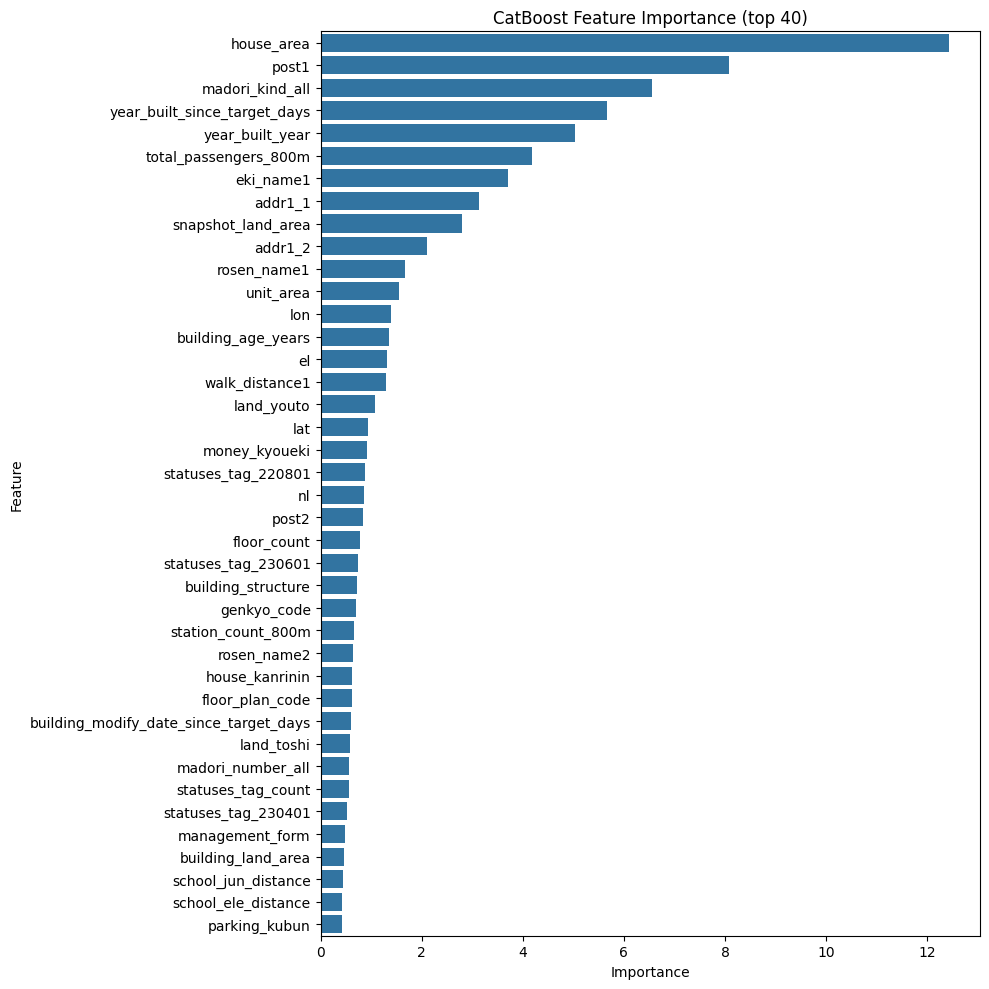

,feature,importance
0,house_area,12.423859
1,post1,8.083189
2,madori_kind_all,6.555763
3,year_built_since_target_days,5.660370
4,year_built_year,5.036577
5,total_passengers_800m,4.181377
6,eki_name1,3.705521
7,addr1_1,3.126765
8,snapshot_land_area,2.796381
9,addr1_2,2.113091


In [20]:
# セル3: 全データで再学習して特徴量重要度を可視化

# 全データ (X, y_log) で学習
best_params.update({
    "use_best_model": False,
})
model_full = CatBoostRegressor(**best_params)
model_full.fit(
    X, y_log,
    cat_features=cat_feature_indices,
    verbose=False,
)

# CatBoost の特徴量重要度 (PredictionValuesChange がデフォルト)
importances = model_full.get_feature_importance()
fi_df = pd.DataFrame({
    "feature": X.columns,
    "importance": importances,
})

# 重要度の高い順にソート
fi_df = fi_df.sort_values("importance", ascending=False).reset_index(drop=True)

# 上位 N 個だけプロット（多すぎると見づらいので）
TOP_N = 40
top_fi = fi_df.head(TOP_N)

plt.figure(figsize=(10, max(6, TOP_N * 0.25)))
sns.barplot(data=top_fi, x="importance", y="feature")
plt.title(f"CatBoost Feature Importance (top {TOP_N})")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# 上位 50 くらいは表でも見たいとき
fi_df.head(50)


In [21]:
from datetime import datetime

# 提出用ファイル作成

# 予測の長さチェック（任意）
print("len(test)          :", len(test))
print("len(test_pred_mean):", len(test_pred_mean))

# id と予測値を結合
sub = pd.DataFrame({
    "id": test["id"].values,
    "pred": test_pred_mean,
})

# id を 6桁ゼロ埋め（サンプル形式に合わせる）
sub["id"] = sub["id"].astype(str).str.zfill(6)

# 中身確認
print(sub.head())

# タイムスタンプ付きファイル名を作成（例: submission_20251130_032501.csv）
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"{PATH}submit/submission_{timestamp}.csv"

# ヘッダー無し & インデックス無しで保存
sub.to_csv(filename, header=False, index=False)

print("saved:", filename)


len(test)          : 112437
len(test_pred_mean): 112437
       id          pred
0  000000  1.429598e+07
1  000001  1.803372e+07
2  000002  2.008137e+07
3  000003  2.256945e+07
4  000004  1.553904e+07


saved: /home/murakami/SIGNATE/mlit-geospatial-challenge-2/data/submit/submission_20260131_133315.csv
